# Week 1 — EV Price Prediction (Executable notebook)

Instructions:
- Upload `electric_vehicles_spec_2025.csv.csv` (or `raw_ev_dataset.csv`) to the same folder.
- This notebook performs: loading, cleaning, EDA, preprocessing, and LightGBM training.
- Optimized for accuracy & runtime on a laptop. Set `SMALL_RUN=True` for quick/low-RAM runs.


In [8]:
# Settings & Dependencies
SMALL_RUN = False  # set True to subsample (useful for low-RAM laptops)
DATA_PATHS = [
    'electric_vehicles_spec_2025.csv.csv',
    './electric_vehicles_spec_2025.csv.csv',
    'raw_ev_dataset.csv',
    './raw_ev_dataset.csv'
]
OUTPUT_CLEAN = 'cleaned_ev_data.csv'
SEED = 42
N_THREADS = -1  # use all cores; set to 1 for single-threaded


In [9]:
# Install missing packages (run once per environment)
%pip install -q lightgbm category_encoders seaborn matplotlib scikit-learn joblib


In [10]:
# Install missing packages (uncomment if running in fresh environment)
%pip install -q lightgbm

import os
import gc
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import category_encoders as ce
import joblib

np.random.seed(SEED)


## 1) Load dataset (tries multiple paths)


In [11]:
def load_dataset(paths):
    for p in paths:
        if os.path.exists(p):
            print(f'Loading: {p}')
            return pd.read_csv(p)
    raise FileNotFoundError('No dataset found. Place electric_vehicles_spec_2025.csv.csv \n'
                            'or raw_ev_dataset.csv in this folder, or update DATA_PATHS.')


#df = load_dataset(DATA_PATHS) # Comment out the original load
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("afnansaifafnan/electric-car-performance-and-battery-dataset")

print("Path to dataset files:", path)

# Construct the full path to the CSV file(s) within the downloaded dataset
# Assuming the CSV file is directly within the downloaded directory
dataset_file_path = os.path.join(path, 'electric_vehicles_spec_2025.csv.csv') # Adjust filename if needed
df = pd.read_csv(dataset_file_path)


print('Initial shape:', df.shape)

Path to dataset files: /root/.cache/kagglehub/datasets/afnansaifafnan/electric-car-performance-and-battery-dataset/versions/1
Initial shape: (478, 22)


In [12]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("afnansaifafnan/electric-car-performance-and-battery-dataset")

print("Path to dataset files:", path)

# List files in the downloaded directory
print("Files in the downloaded directory:")
for root, dirs, files in os.walk(path):
    for name in files:
        print(os.path.join(root, name))

Path to dataset files: /root/.cache/kagglehub/datasets/afnansaifafnan/electric-car-performance-and-battery-dataset/versions/1
Files in the downloaded directory:
/root/.cache/kagglehub/datasets/afnansaifafnan/electric-car-performance-and-battery-dataset/versions/1/electric_vehicles_spec_2025.csv.csv


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2) Quick inspection


In [14]:
display(df.head())
print(df.info())
display(df.describe(include='all').T)


,brand,model,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,...,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url
0,Abarth,500e Convertible,155,37.8,Lithium-ion,192.0,235.0,156,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1904/Abarth-500e-C...
1,Abarth,500e Hatchback,155,37.8,Lithium-ion,192.0,235.0,149,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1903/Abarth-500e-H...
2,Abarth,600e Scorpionissima,200,50.8,Lithium-ion,102.0,345.0,158,280,5.9,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3057/Abarth-600e-S...
3,Abarth,600e Turismo,200,50.8,Lithium-ion,102.0,345.0,158,280,6.2,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3056/Abarth-600e-T...
4,Aiways,U5,150,60.0,Lithium-ion,NaN,310.0,156,315,7.5,...,NaN,496,5,FWD,JC - Medium,4680,1865,1700,SUV,https://ev-database.org/car/1678/Aiways-U5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand                      478 non-null    object 
 1   model                      477 non-null    object 
 2   top_speed_kmh              478 non-null    int64  
 3   battery_capacity_kWh       478 non-null    float64
 4   battery_type               478 non-null    object 
 5   number_of_cells            276 non-null    float64
 6   torque_nm                  471 non-null    float64
 7   efficiency_wh_per_km       478 non-null    int64  
 8   range_km                   478 non-null    int64  
 9   acceleration_0_100_s       478 non-null    float64
 10  fast_charging_power_kw_dc  477 non-null    float64
 11  fast_charge_port           477 non-null    object 
 12  towing_capacity_kg         452 non-null    float64
 13  cargo_volume_l             477 non-null    object 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand,478,59,Mercedes-Benz,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,477,477,X Privilege AWD (MY25),1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top_speed_kmh,478.0,NaN,NaN,NaN,185.487448,34.252773,125.0,160.0,180.0,201.0,325.0
battery_capacity_kWh,478.0,NaN,NaN,NaN,74.043724,20.331058,21.3,60.0,76.15,90.6,118.0
battery_type,478,1,Lithium-ion,478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_of_cells,276.0,NaN,NaN,NaN,485.293478,1210.819733,72.0,150.0,216.0,324.0,7920.0
torque_nm,471.0,NaN,NaN,NaN,498.012739,241.461128,113.0,305.0,430.0,679.0,1350.0
efficiency_wh_per_km,478.0,NaN,NaN,NaN,162.903766,34.317532,109.0,143.0,155.0,177.75,370.0
range_km,478.0,NaN,NaN,NaN,393.179916,103.287335,135.0,320.0,397.5,470.0,685.0
acceleration_0_100_s,478.0,NaN,NaN,NaN,6.882636,2.730696,2.2,4.8,6.6,8.2,19.1


## 3) Lightweight cleaning pipeline optimized for speed


In [15]:
# Keep a copy of original
raw = df.copy()

# Standardize column names
df.columns = [c.strip().lower() for c in df.columns]

# Map common synonyms to canonical names
rename_map = {
    'brand': 'manufacturer',
    'car_body_type': 'type',
    'drivetrain': 'drive_type',
    'battery_capacity_kwh': 'battery_kwh',
    'top_speed_kmh': 'top_speed_kmph'
}
for src, dst in rename_map.items():
    if src in df.columns and dst not in df.columns:
        df.rename(columns={src: dst}, inplace=True)

# Create efficiency_score if missing (km per kWh)
if 'efficiency_score' not in df.columns and 'efficiency_wh_per_km' in df.columns:
    df['efficiency_score'] = 1000.0 / pd.to_numeric(df['efficiency_wh_per_km'], errors='coerce')

# Determine target column (fallback to 'range_km' if price not available)
TARGET = 'price_usd'
if TARGET not in df.columns:
    if 'range_km' in df.columns:
        TARGET = 'range_km'
        print("'price_usd' not found. Falling back to target = 'range_km'.")
    else:
        raise ValueError("Neither 'price_usd' nor 'range_km' found in dataset. Provide a dataset with a target column.")
print('Using target:', TARGET)

# Essential columns check (dynamic, excluding the target if duplicated)
required = ['manufacturer','model','type','drive_type','battery_kwh','range_km',
            'charging_time_hr','release_year',TARGET,'efficiency_score',
            'top_speed_kmph','safety_rating','target_high_efficiency']
present = [c for c in required if c in df.columns]
print('Required present columns:', len(present), 'of', len(required))

# If SMALL_RUN, sample
if SMALL_RUN:
    df = df.sample(frac=0.1, random_state=SEED)
    print('Small run enabled. New shape:', df.shape)

# Convert numeric columns safely
num_cols = ['battery_kwh','range_km','charging_time_hr',TARGET,'efficiency_score',
            'top_speed_kmph','safety_rating','release_year']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Trim whitespace in string columns and normalize manufacturer
for c in ['manufacturer','model','type','drive_type']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()
        if c == 'manufacturer':
            df[c] = df[c].str.title()

# Drop exact duplicates
df.drop_duplicates(inplace=True)
print('After dedup:', df.shape)


'price_usd' not found. Falling back to target = 'range_km'.
Using target: range_km
Required present columns: 9 of 13
After dedup: (478, 23)


### Missing values strategy (fast & pragmatic)


In [16]:
# Report missing
miss = df.isnull().mean().sort_values(ascending=False)
print('Missing % per column:\n', (miss*100).head(20))

# For numeric columns: impute with median
for c in [col for col in df.columns if df[col].dtype.kind in 'biufc']:
    median = df[c].median()
    df[c].fillna(median, inplace=True)

# For categorical columns: fill with 'Unknown'
for c in [col for col in df.columns if df[col].dtype == 'object']:
    df[c].fillna('Unknown', inplace=True)

# If target has missing — drop those rows
if TARGET in df.columns:
    df = df[df[TARGET].notnull()]
    if len(df) == 0:
        raise ValueError(f"After dropping missing '{TARGET}', no rows remain. Check dataset.")
else:
    raise ValueError(f"Required target column '{TARGET}' not found in dataset.")

print('After basic imputation:', df.shape)


Missing % per column:
 number_of_cells              42.259414
towing_capacity_kg            5.439331
torque_nm                     1.464435
cargo_volume_l                0.209205
fast_charge_port              0.209205
fast_charging_power_kw_dc     0.209205
manufacturer                  0.000000
battery_kwh                   0.000000
battery_type                  0.000000
model                         0.000000
top_speed_kmph                0.000000
acceleration_0_100_s          0.000000
range_km                      0.000000
efficiency_wh_per_km          0.000000
seats                         0.000000
drive_type                    0.000000
segment                       0.000000
length_mm                     0.000000
width_mm                      0.000000
height_mm                     0.000000
dtype: float64
After basic imputation: (478, 23)


### Outlier handling (clipped to reasonable ranges)


In [17]:
# Clip numeric extremes based on reasonable ranges
clip_specs = {
    'price_usd': (1000, 250000),
    'battery_kwh': (5, 250),
    'range_km': (50, 1500),
    'top_speed_kmph': (50, 400),
    'charging_time_hr': (0.1, 72)
}
for c, (lo, hi) in clip_specs.items():
    if c in df.columns:
        df[c] = df[c].clip(lower=lo, upper=hi)


## 4) Quick EDA (visuals optimized for speed)


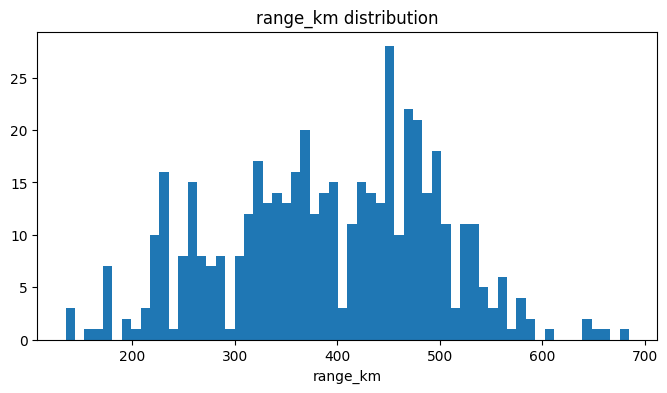

,battery_kwh,range_km,top_speed_kmph,efficiency_score
battery_kwh,1.000000,0.880433,0.708486,-0.517702
range_km,0.880433,1.000000,0.732130,-0.149615
top_speed_kmph,0.708486,0.732130,1.000000,-0.294535
efficiency_score,-0.517702,-0.149615,-0.294535,1.000000


In [18]:
plt.rcParams['figure.figsize'] = (8, 4)

if TARGET in df.columns and df[TARGET].dtype.kind in 'biufc':
    plt.hist(df[TARGET].dropna(), bins=60)
    plt.title(f'{TARGET} distribution')
    plt.xlabel(TARGET)
    plt.show()

# Basic correlations (guarded by column presence)
base_cols = ['battery_kwh','range_km','price_usd','top_speed_kmph','efficiency_score']
cols_for_corr = []
for c in base_cols + [TARGET]:
    if c in df.columns and c not in cols_for_corr and df[c].dtype.kind in 'biufc':
        cols_for_corr.append(c)
if len(cols_for_corr) >= 2:
    corr_sample = df.sample(n=min(50000, len(df)), random_state=SEED)
    display(corr_sample[cols_for_corr].corr())


## 5) Feature engineering & encoding (fast, effective)


In [19]:
# Derived features
if 'battery_kwh' in df.columns and 'range_km' in df.columns and TARGET != 'range_km':
    # Only create wh_per_km when not predicting range to avoid leakage
    df['wh_per_km'] = (df['battery_kwh'] * 1000) / df['range_km']

# Reduce cardinality for manufacturer
if 'manufacturer' in df.columns:
    topm = df['manufacturer'].value_counts().nlargest(20).index
    df['manufacturer_top'] = df['manufacturer'].where(df['manufacturer'].isin(topm), 'Other')

# Cast categories for memory/perf
for c in ['manufacturer_top','type','drive_type']:
    if c in df.columns:
        df[c] = df[c].astype('category')

# Target transform
df['target_log'] = np.log1p(df[TARGET]) if df[TARGET].dtype.kind in 'biufc' else df[TARGET]

# Define predictors
candidate_features = ['battery_kwh','range_km','charging_time_hr','efficiency_score',
                      'top_speed_kmph','safety_rating','release_year','wh_per_km',
                      'manufacturer_top','type','drive_type']
# Exclude target from features
candidate_features = [c for c in candidate_features if c != TARGET]
features = [c for c in candidate_features if c in df.columns]
print('Features used:', features)
print('Target used:', TARGET)


Features used: ['battery_kwh', 'efficiency_score', 'top_speed_kmph', 'manufacturer_top', 'type', 'drive_type']
Target used: range_km


## 6) Train / Test split


In [20]:
X = df[features].copy()
y = df['target_log']

# Fill remaining NaNs: numeric only; categorical already handled above
num_cols_X = X.select_dtypes(include=['number']).columns
X[num_cols_X] = X[num_cols_X].fillna(-999)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (382, 6) Test shape: (96, 6)


### Target encoding for manufacturer_top and category casting


In [21]:
cat_enc_cols = ['manufacturer_top'] if 'manufacturer_top' in X_train.columns else []
if cat_enc_cols:
    te = ce.TargetEncoder(cols=cat_enc_cols)
    X_train = te.fit_transform(X_train, y_train)
    X_test = te.transform(X_test)
else:
    te = None

# Cast any remaining object/categorical columns to category for LightGBM
for c in X_train.select_dtypes(include=['object', 'category']).columns:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')


## 7) LightGBM training (fast + accurate)


In [22]:
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data, free_raw_data=False)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_threads': -1 if N_THREADS == -1 else N_THREADS,
    'seed': SEED,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

# Train baseline model with early stopping via callbacks
bst = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)


Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.0905273
[100]	valid_0's rmse: 0.0794846
[150]	valid_0's rmse: 0.0767624
[200]	valid_0's rmse: 0.0758208
[250]	valid_0's rmse: 0.0738981
[300]	valid_0's rmse: 0.0738355
Early stopping, best iteration is:
[260]	valid_0's rmse: 0.0731858


## 8) Evaluation (log target back-transformed)


RMSE: 24.15, MAE: 17.69, R2: 0.9449
MAPE: 4.99% | sMAPE: 5.01% | Median AE: 12.23
Residuals (y - yhat) quantiles: 5%=-30.18, 50%=-0.43, 95%=47.74


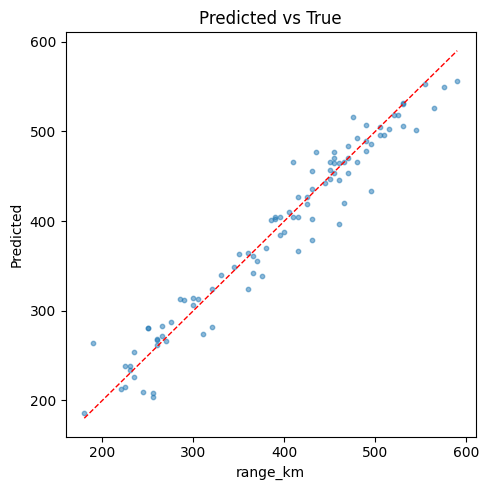

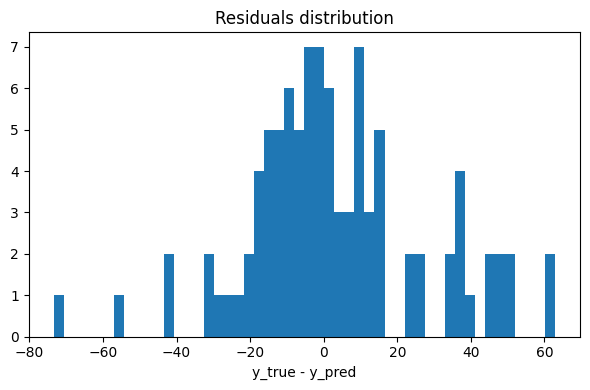

In [23]:
pred_log = bst.predict(X_test, num_iteration=bst.best_iteration)
pred = np.expm1(pred_log)

y_true = np.expm1(y_test)

mse = mean_squared_error(y_true, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, pred)
r2 = r2_score(y_true, pred)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}')

# Additional evaluation metrics and diagnostics
import numpy as _np
import matplotlib.pyplot as _plt

y_true_np = _np.asarray(y_true)
pred_np = _np.asarray(pred)
resid = y_true_np - pred_np

mask = y_true_np != 0
mape = float(_np.mean(_np.abs((y_true_np[mask] - pred_np[mask]) / y_true_np[mask])) * 100) if mask.any() else _np.nan
smape = float(100 * _np.mean(2*_np.abs(pred_np - y_true_np) / (_np.abs(y_true_np) + _np.abs(pred_np))))
med_ae = float(_np.median(_np.abs(resid)))
p5, p50, p95 = _np.quantile(resid, [0.05, 0.5, 0.95])

print(f"MAPE: {mape:.2f}% | sMAPE: {smape:.2f}% | Median AE: {med_ae:.2f}")
print(f"Residuals (y - yhat) quantiles: 5%={p5:.2f}, 50%={p50:.2f}, 95%={p95:.2f}")

# Scatter plot: predicted vs true
_plt.figure(figsize=(5, 5))
_plt.scatter(y_true_np, pred_np, s=10, alpha=0.5)
minv = float(_np.nanmin([y_true_np.min(), pred_np.min()]))
maxv = float(_np.nanmax([y_true_np.max(), pred_np.max()]))
_plt.plot([minv, maxv], [minv, maxv], 'r--', linewidth=1)
_plt.xlabel(TARGET)
_plt.ylabel('Predicted')
_plt.title('Predicted vs True')
_plt.tight_layout()
_plt.show()

# Residuals histogram
_plt.figure(figsize=(6, 4))
_plt.hist(resid, bins=50)
_plt.title('Residuals distribution')
_plt.xlabel('y_true - y_pred')
_plt.tight_layout()
_plt.show()


## 9) Feature importance


,feature,importance
0,battery_kwh,165.290400
2,top_speed_kmph,60.705568
1,efficiency_score,19.940966
3,manufacturer_top,9.673616
5,drive_type,2.964295
4,type,1.044232


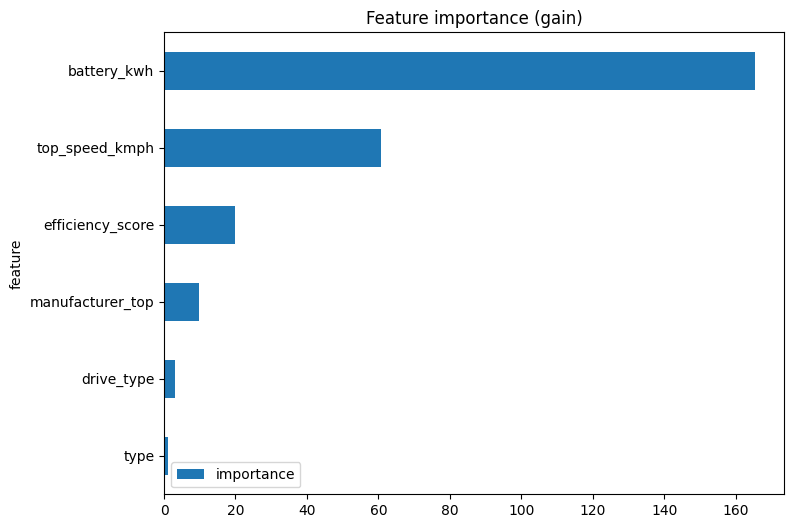

In [24]:
fi = bst.feature_importance(importance_type='gain')
feat_names = bst.feature_name()
fi_df = pd.DataFrame({'feature': feat_names, 'importance': fi}).sort_values('importance', ascending=False)
display(fi_df.head(20))
fi_df.set_index('feature').plot.barh(figsize=(8,6))
plt.gca().invert_yaxis()
plt.title('Feature importance (gain)')
plt.show()


## 10) Save cleaned data and model


In [25]:
# Save cleaned data
OUTPUT_CLEAN = 'cleaned_ev_data.csv'
df.to_csv(OUTPUT_CLEAN, index=False)
print('Saved cleaned dataset to', OUTPUT_CLEAN)

# Save model and target encoder (two formats for robustness)
joblib.dump(bst, 'lgb_model.pkl')
bst.save_model('lgb_model.txt')
if te is not None:
    joblib.dump(te, 'target_encoder.pkl')
print('Saved model artifacts: lgb_model.pkl, lgb_model.txt')


Saved cleaned dataset to cleaned_ev_data.csv
Saved model artifacts: lgb_model.pkl, lgb_model.txt


## 11) Notes
- For best accuracy: try longer hyperparameter search or Optuna.
- If you have GPU-enabled LightGBM, switch boosting to GPU.
- Consider ensembling LightGBM with XGBoost/CatBoost.


In [26]:
# Clip numeric extremes based on quantiles to reduce impact of bad scraping
clip_specs = {
    'price_usd': (1000, 250000),
    'battery_kwh': (5, 250),
    'range_km': (50, 1500),
    'top_speed_kmph': (50, 400),
    'charging_time_hr': (0.1, 72)
}
for c, (lo, hi) in clip_specs.items():
    if c in df.columns:
        df[c] = df[c].clip(lower=lo, upper=hi)


In [27]:
# Example new data (replace with your actual new data)
new_data = pd.DataFrame({
    'battery_kwh': [50.0, 75.0],
    'efficiency_score': [6.5, 7.0],
    'top_speed_kmph': [180, 200],
    'manufacturer_top': ['Other', 'Other'],
    'type': ['SUV', 'Hatchback'],
    'drive_type': ['FWD', 'AWD']
})

# Ensure all required training columns exist
for c in X_train.columns:
    if c not in new_data.columns:
        if str(X_train[c].dtype) == 'category':
            new_data[c] = 'Unknown'
        else:
            new_data[c] = -999

# Align dtypes/categories with training data
for c in X_train.columns:
    if str(X_train[c].dtype) == 'category':
        cats = X_train[c].cat.categories
        new_data[c] = pd.Categorical(new_data[c], categories=cats)
    else:
        new_data[c] = pd.to_numeric(new_data[c], errors='coerce').fillna(-999)

# Apply target encoder if used (must pass the same columns as during fit)
if 'te' in globals() and te is not None:
    new_data_transformed = te.transform(new_data[X_train.columns])
else:
    new_data_transformed = new_data[X_train.columns]

# Predict using the trained model on the selected features
new_data_predictions_log = bst.predict(new_data_transformed[features], num_iteration=bst.best_iteration)
new_data_predictions = np.expm1(new_data_predictions_log)

print("Predictions (log scale):", new_data_predictions_log)
print("Predictions (original scale):", new_data_predictions)

Predictions (log scale): [5.66800038 6.16081828]
Predictions (original scale): [288.45515583 472.81563138]
